## CNN (リサーチワークショップⅡ, 2024)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

In [2]:
# 再現性を担保するため，乱数を固定
np.random.seed(1234)
torch.manual_seed(1234)

# 演算に用いるデバイスを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tensor へ変換するための transforms
transform = transforms.Compose([transforms.ToTensor()])
'''
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
'''

# データの取得
root = os.path.join('data', 'mnist')
mnist_train = torchvision.datasets.MNIST(root=root, download=True, train=True,
                                         transform=transforms.ToTensor())
mnist_test =  torchvision.datasets.MNIST(root=root, download=True, train=False,
                                         transform=transforms.ToTensor())

# data loader の定義
batch_size = 32
train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [3]:
x, _ = next(iter(test_dataloader))
print(x.shape) # [32, 1, 28, 28]

torch.Size([32, 1, 28, 28])


In [4]:
# モデル CNN の定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3,  stride=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Linear(5*5*32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # print(x.shape)
        #import sys
        #sys.exit()
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
# モデルのインスタンス化
model = Net().to(device)

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
from torchsummary import summary
model = Net().to(device)
summary(model, (1, 28, 28))

ModuleNotFoundError: No module named 'torchsummary'

In [7]:
from tqdm import tqdm

epochs = 50 # 100

train_loss_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(epochs):
    # 学習
    model.train()

    running_loss = 0
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) # 順伝播
        loss = criterion(outputs, labels) # 誤差
        running_loss += loss.item()
        loss.backward() # 誤差の逆伝播
        optimizer.step() # パラメータ更新


    train_loss = running_loss / len(train_dataloader)
    train_loss_history.append(train_loss) # 損失の記録

    # テスト
    model.eval()
    
    running_loss = 0
    total = 0 # データ数
    correct = 0 # 正解数を保存
    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        ### optimizer.zero_grad()
        outputs = model(images) # 順伝播
        loss = criterion(outputs, labels) # 誤差
        running_loss += loss.item()
        ### loss.backward() # 誤差の逆伝播
        ### optimizer.step() # パラメータ更新

        predicted = torch.argmax(outputs, dim=1)
        correct += torch.sum(predicted == labels)
        total += labels.size(0)
        '''
        print(labels)
        print(predicted)
        '''

        '''
        import sys
        sys.exit()
        '''
        
    test_loss = running_loss / len(test_dataloader)
    test_acc = correct.item() / total
    test_loss_history.append(test_loss) # 損失の記録
    test_acc_history.append(test_acc)

    print('Epoch: {}, Train Loss: {:5f}, Test Loss: {:5f}, Test Accuracy: {:5f}'.format(epoch+1,
                                                                               train_loss,
                                                                               test_loss,
                                                                               test_acc))

    # latent space の状態を描画
    ### plot_latent_space(epoch+1)

100%|████████████████████████████████████████| 313/313 [00:00<00:00, 314.11it/s]


Epoch: 1, Train Loss: 0.214928, Test Loss: 0.073786, Test Accuracy: 0.976100


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 342.33it/s]


Epoch: 2, Train Loss: 0.071283, Test Loss: 0.050967, Test Accuracy: 0.982600


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 327.47it/s]


Epoch: 3, Train Loss: 0.054571, Test Loss: 0.042846, Test Accuracy: 0.985200


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 322.67it/s]


Epoch: 4, Train Loss: 0.043607, Test Loss: 0.042069, Test Accuracy: 0.986600


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 317.62it/s]


Epoch: 5, Train Loss: 0.036771, Test Loss: 0.033810, Test Accuracy: 0.988700


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 298.88it/s]


Epoch: 6, Train Loss: 0.032069, Test Loss: 0.036563, Test Accuracy: 0.987800


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 306.84it/s]


Epoch: 7, Train Loss: 0.027681, Test Loss: 0.040484, Test Accuracy: 0.986000


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 287.44it/s]


Epoch: 8, Train Loss: 0.024074, Test Loss: 0.031501, Test Accuracy: 0.989200


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 307.76it/s]


Epoch: 9, Train Loss: 0.021884, Test Loss: 0.036151, Test Accuracy: 0.987400


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 313.45it/s]


Epoch: 10, Train Loss: 0.018674, Test Loss: 0.033446, Test Accuracy: 0.989000


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 309.33it/s]


Epoch: 11, Train Loss: 0.016291, Test Loss: 0.033149, Test Accuracy: 0.989000


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 314.36it/s]


Epoch: 12, Train Loss: 0.013657, Test Loss: 0.038421, Test Accuracy: 0.988900


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 306.56it/s]


Epoch: 13, Train Loss: 0.013577, Test Loss: 0.031811, Test Accuracy: 0.990000


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 314.42it/s]


Epoch: 14, Train Loss: 0.011976, Test Loss: 0.037914, Test Accuracy: 0.988100


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 311.75it/s]


Epoch: 15, Train Loss: 0.010525, Test Loss: 0.036856, Test Accuracy: 0.988900


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 312.12it/s]


Epoch: 16, Train Loss: 0.009754, Test Loss: 0.048109, Test Accuracy: 0.986900


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 300.74it/s]


Epoch: 17, Train Loss: 0.009060, Test Loss: 0.035490, Test Accuracy: 0.989500


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 313.56it/s]


Epoch: 18, Train Loss: 0.008319, Test Loss: 0.033752, Test Accuracy: 0.989900


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 316.17it/s]


Epoch: 19, Train Loss: 0.007512, Test Loss: 0.038594, Test Accuracy: 0.990200


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 309.95it/s]


Epoch: 20, Train Loss: 0.006429, Test Loss: 0.048048, Test Accuracy: 0.986400


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 306.88it/s]


Epoch: 21, Train Loss: 0.006838, Test Loss: 0.043657, Test Accuracy: 0.987900


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 306.83it/s]


Epoch: 22, Train Loss: 0.005825, Test Loss: 0.055493, Test Accuracy: 0.987100


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 311.80it/s]


Epoch: 23, Train Loss: 0.005627, Test Loss: 0.049050, Test Accuracy: 0.988300


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 319.23it/s]


Epoch: 24, Train Loss: 0.004324, Test Loss: 0.047209, Test Accuracy: 0.989000


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 319.38it/s]


Epoch: 25, Train Loss: 0.004845, Test Loss: 0.048206, Test Accuracy: 0.988700


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 319.99it/s]


Epoch: 26, Train Loss: 0.003796, Test Loss: 0.052972, Test Accuracy: 0.988800


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 302.87it/s]


Epoch: 27, Train Loss: 0.004871, Test Loss: 0.045443, Test Accuracy: 0.991000


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 301.20it/s]


Epoch: 28, Train Loss: 0.003926, Test Loss: 0.056604, Test Accuracy: 0.987700


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 309.89it/s]


Epoch: 29, Train Loss: 0.003949, Test Loss: 0.049625, Test Accuracy: 0.988200


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 308.13it/s]


Epoch: 30, Train Loss: 0.003254, Test Loss: 0.062167, Test Accuracy: 0.986800


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 305.56it/s]


Epoch: 31, Train Loss: 0.003899, Test Loss: 0.041770, Test Accuracy: 0.989800


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 311.33it/s]


Epoch: 32, Train Loss: 0.003227, Test Loss: 0.047501, Test Accuracy: 0.989900


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 304.94it/s]


Epoch: 33, Train Loss: 0.002884, Test Loss: 0.049818, Test Accuracy: 0.990100


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 309.90it/s]


Epoch: 34, Train Loss: 0.003245, Test Loss: 0.049617, Test Accuracy: 0.988500


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 307.36it/s]


Epoch: 35, Train Loss: 0.002589, Test Loss: 0.046552, Test Accuracy: 0.990900


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 308.65it/s]


Epoch: 36, Train Loss: 0.003383, Test Loss: 0.056703, Test Accuracy: 0.989000


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 306.06it/s]


Epoch: 37, Train Loss: 0.002305, Test Loss: 0.055932, Test Accuracy: 0.989200


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 328.12it/s]


Epoch: 38, Train Loss: 0.003285, Test Loss: 0.063193, Test Accuracy: 0.988300


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 301.08it/s]


Epoch: 39, Train Loss: 0.001980, Test Loss: 0.067443, Test Accuracy: 0.986800


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 312.23it/s]


Epoch: 40, Train Loss: 0.003031, Test Loss: 0.058756, Test Accuracy: 0.988400


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 304.27it/s]


Epoch: 41, Train Loss: 0.002420, Test Loss: 0.069873, Test Accuracy: 0.987900


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 314.45it/s]


Epoch: 42, Train Loss: 0.001999, Test Loss: 0.055390, Test Accuracy: 0.989700


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 305.64it/s]


Epoch: 43, Train Loss: 0.003162, Test Loss: 0.062127, Test Accuracy: 0.988300


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 314.56it/s]


Epoch: 44, Train Loss: 0.000924, Test Loss: 0.059668, Test Accuracy: 0.989500


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 335.38it/s]


Epoch: 45, Train Loss: 0.002857, Test Loss: 0.051650, Test Accuracy: 0.990300


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 314.88it/s]


Epoch: 46, Train Loss: 0.002503, Test Loss: 0.056869, Test Accuracy: 0.988800


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 301.80it/s]


Epoch: 47, Train Loss: 0.001632, Test Loss: 0.071925, Test Accuracy: 0.988200


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 312.62it/s]


Epoch: 48, Train Loss: 0.002679, Test Loss: 0.063733, Test Accuracy: 0.989000


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 329.92it/s]


Epoch: 49, Train Loss: 0.002650, Test Loss: 0.058149, Test Accuracy: 0.989200


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 311.12it/s]

Epoch: 50, Train Loss: 0.001223, Test Loss: 0.069707, Test Accuracy: 0.989300


In [16]:
train_loss_history

[0.05393103964665982, 0.05484753033002222]

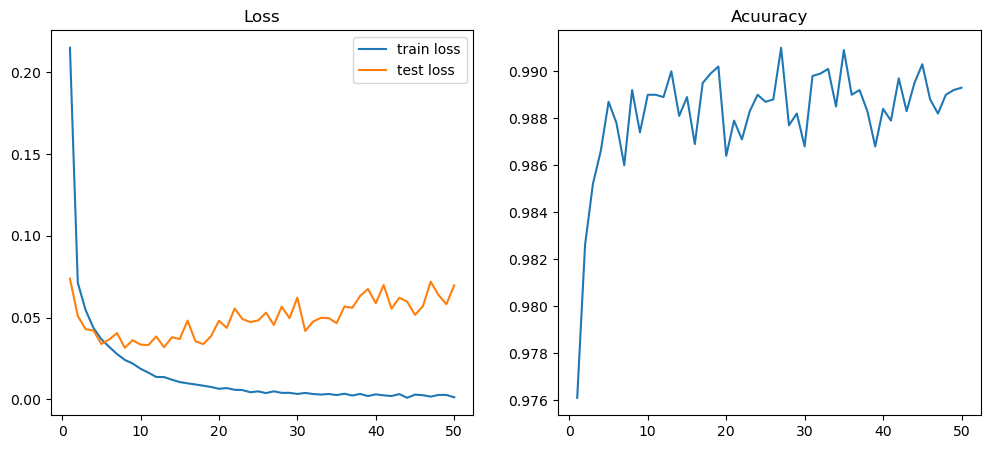

In [8]:
# 損失，正解率の可視化
import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_loss_history)+1) # x軸

train_loss_history = np.array(train_loss_history) # y軸
test_loss_history = np.array(test_loss_history) # y軸
test_acc_history = np.array(test_acc_history) # y軸

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Loss')
ax1.plot(epochs, train_loss_history, label="train loss")
ax1.plot(epochs, test_loss_history, label="test loss")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
### ax2.set_ylim([0.9, 1.0])
ax2.set_title('Acuuracy')
ax2.plot(epochs, test_acc_history)

plt.show()

100%|████████████████████████████████████████| 313/313 [00:00<00:00, 321.77it/s]


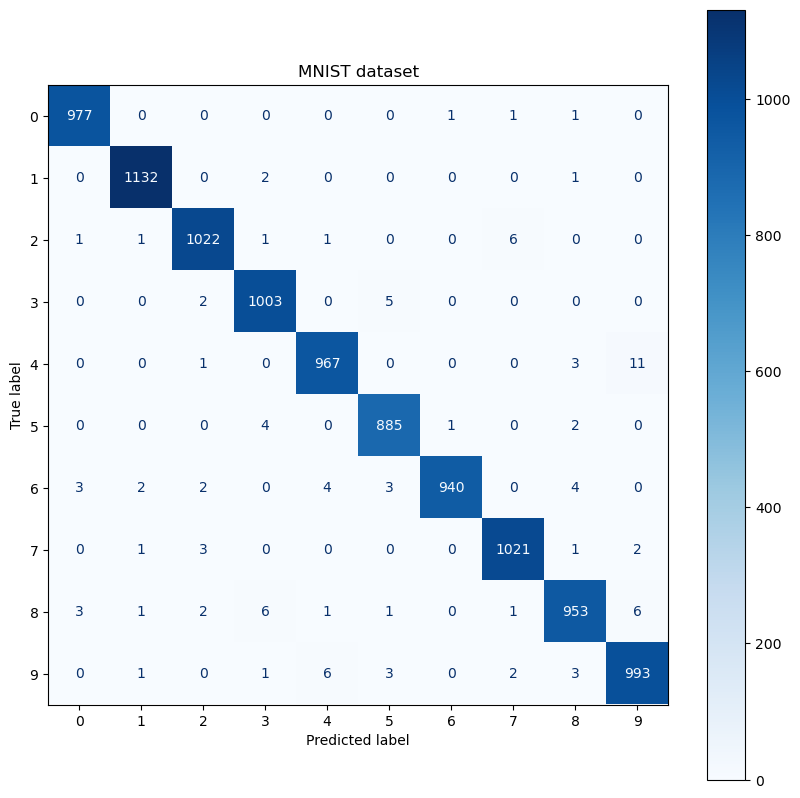

In [9]:
cm_predicted_list = [] # confusion matrix で利用するため予測値を蓄える
cm_true_list = [] # confusion matrix で利用するため真値を蓄える
    
for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    ### optimizer.zero_grad()
    outputs = model(images) # 順伝播
    loss = criterion(outputs, labels) # 誤差
    running_loss += loss.item()
    ### loss.backward() # 誤差の逆伝播
    ### optimizer.step() # パラメータ更新

    predicted = torch.argmax(outputs, dim=1)

    # confusion matrix のため予測値／真値を蓄える
    cm_predicted_list += predicted.tolist()
    cm_true_list += labels.tolist()
        
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(cm_true_list, cm_predicted_list)
# cmp = ConfusionMatrixDisplay(cm, display_labels=['b_fully_ripened', 'b_half_ripened', 'b_green'])
cmp = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('MNIST dataset')
# cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax) 
cmp.plot(cmap=plt.cm.Blues, ax=ax) 